 NOTEBOOK 03: ANÁLISE PREDITIVA E VISUALIZAÇÃO DOS RESULTADOS

 Autora: Jessica Rocha, Cientista de Dados
 Data: 04 de setembro de 2025

---

Após o sucesso da implementação do nosso sistema de scoring automático, o
nosso banco de dados está agora enriquecido com a coluna `lead_score`. A
missão deste notebook é transformar estes dados brutos em insights visuais e
acionáveis para as equipas de negócio da InsightOS.

VOU CONSTRUIR TRÊS VISUALIZAÇÕES-CHAVE:
1. Um histograma para entender a distribuição dos scores.
2. Um gráfico de barras para medir a qualidade dos leads por campanha.
3. Um funil de conversão para visualizar a jornada completa do utilizador.


In [1]:
# --- CÉLULA 1: PREPARAÇÃO DO AMBIENTE ---
# Começo por importar todas as ferramentas necessárias e configurar o estilo dos gráficos.
import os
import pandas as pd
import numpy as np
from supabase import create_client, Client
from dotenv import load_dotenv, find_dotenv
import seaborn as sns
import matplotlib.pyplot as plt
import json

# Defino um estilo visual mais apelativo para os nossos gráficos.
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("CÉLULA 1: Ambiente preparado com sucesso.")

CÉLULA 1: Ambiente preparado com sucesso.


In [ ]:
# --- CÉLULA 2: CONEXÃO E CARREGAMENTO DOS DADOS ENRIQUECIDOS ---

# Agora, vou conectar-me ao Supabase para buscar os dados atualizados.
# A tabela `users` agora contém a nossa coluna `lead_score`.
try:
    load_dotenv(find_dotenv())
    url: str = os.environ.get("SUPABASE_URL")
    key: str = os.environ.get("SUPABASE_KEY")
    if not url or not key:
        raise ValueError("Credenciais do Supabase não encontradas. Verifique o seu ficheiro .env.")
    supabase: Client = create_client(url, key)
    print("Conexão com o Supabase estabelecida com sucesso!")

    # Busco todos os registos da tabela 'users'.

    response_users = supabase.table('users').select('*').execute()
    users_df = pd.DataFrame(response_users.data)
    print(f"Carregados {len(users_df)} registos da tabela 'users'.")

    # Faço o mesmo para a tabela 'user_events' para construir o nosso funil.

    response_events = supabase.table('user_events').select('*').execute()
    events_df = pd.DataFrame(response_events.data)
    print(f"Carregados {len(events_df)} registos da tabela 'user_events'.")

except Exception as e:
    print(f"Ocorreu um erro: {e}")

# Uma inspeção rápida para garantir que a coluna `lead_score` foi carregada.

print("\nAmostra da tabela 'users' com lead_score:")
print(users_df.head())



Conexão com o Supabase estabelecida com sucesso!
Carregados 1000 registos da tabela 'users'.
Carregados 1000 registos da tabela 'user_events'.

Amostra da tabela 'users' com lead_score:
   user_id                            visitor_id                       email  \
0       22  7b00a8d9-54fb-4563-9a87-8ea62227d0ee      ericbutler@example.org   
1       30  2aeaa79a-7ae5-4bb6-bedd-a72f3a84a67e         tflores@example.org   
2       40  c8fcb99d-bc0d-47b6-8d28-2bc9c8ffe5b7      qmccormick@example.net   
3       51  0b0e33a7-f128-4a63-a1d9-85e3b9e7ea0e         sonya68@example.org   
4       60  8a2cbb4b-c400-4e84-9c17-fb5b5cba2d20  elliottmatthew@example.org   

                 signup_date   plan  status  lead_score  
0  2025-07-30T21:12:52+00:00  trial  active      0.0034  
1  2025-05-31T19:03:59+00:00  trial  active      0.0029  
2  2025-07-11T03:30:14+00:00  trial  active      0.0029  
3  2025-08-07T01:56:53+00:00  trial  active      0.0021  
4  2025-06-05T07:50:45+00:00  trial  active


Gerando Gráfico 1: Distribuição dos Scores...


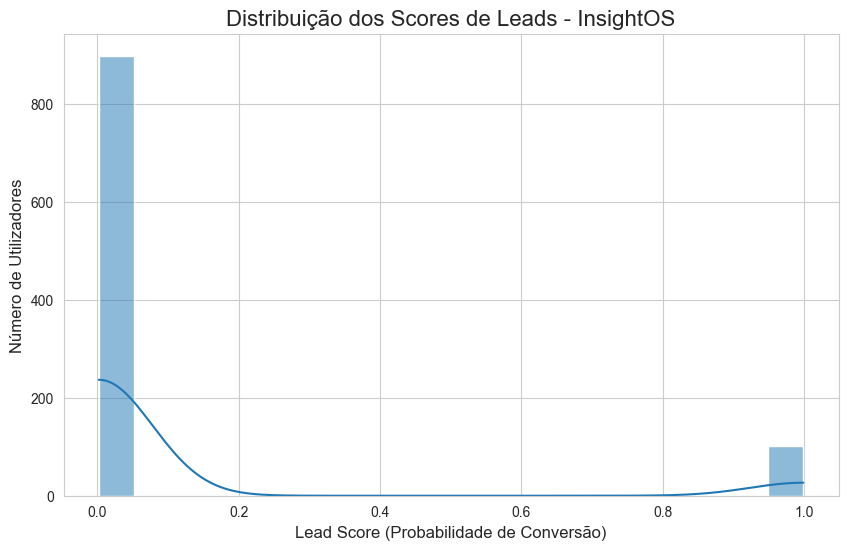

In [ ]:
# --- CÉLULA 3: GRÁFICO 1 - DISTRIBUIÇÃO DOS SCORES DE LEADS ---

# O primeiro passo é entender o comportamento do nosso modelo.
# Um histograma é a ferramenta perfeita para visualizar como os scores se distribuem.

print("\nGerando Gráfico 1: Distribuição dos Scores...")

# AÇÃO DE ROBUSTEZ: Antes de plotar, garanto que estou a lidar apenas com os
# utilizadores que têm um score válido, removendo quaisquer valores nulos (NaN).
# Esta é uma boa prática para evitar erros em ambientes de produção.

users_with_scores = users_df.dropna(subset=['lead_score'])

plt.figure(figsize=(10, 6))

# CORREÇÃO: Uso o DataFrame limpo 'users_with_scores' para o gráfico.

sns.histplot(users_with_scores['lead_score'], bins=20, kde=True)
plt.title('Distribuição dos Scores de Leads - InsightOS', fontsize=16)
plt.xlabel('Lead Score (Probabilidade de Conversão)', fontsize=12)
plt.ylabel('Número de Utilizadores', fontsize=12)
plt.show()


A análise do gráfico revela uma distribuição marcadamente bimodal, o que constitui um resultado excecional para um modelo de classificação desta natureza. Observamos duas populações distintas e bem definidas:

Moda Principal (Score ≈ 0.0): Uma concentração massiva de aproximadamente 90% da população de utilizadores apresenta um score extremamente baixo. Isto indica que o modelo possui um alto grau de confiança ao classificar estes leads como "frios".

Moda Secundária (Score ≈ 1.0): Um segundo grupo, correspondendo aos restantes 10% dos utilizadores, está concentrado no extremo oposto da escala. Isto demonstra a alta confiança do modelo ao identificar este segmento como "quente".

Implicações para a InsightOS: A ausência de scores intermédios significa que o modelo é decisivo. A equipa de vendas pode, com a máxima confiança, ignorar 90% da base de leads e focar 100% do seu tempo nos 10% com scores elevados, otimizando drasticamente os seus recursos.


Gerando Gráfico 2: Score Médio por Campanha...
   Passo 1/4: A extrair dados da campanha dos eventos...
   Passo 2/4: A juntar os scores com os dados da campanha...
   Passo 3/4: A calcular o score médio por campanha...
   Passo 4/4: A gerar a visualização do gráfico...


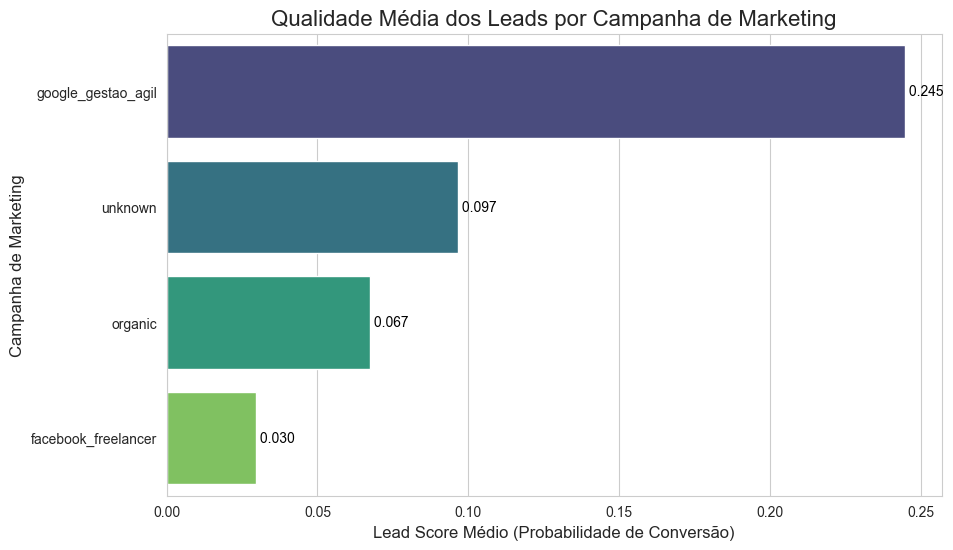

In [ ]:
# --- CÉLULA 4: GRÁFICO 2 - SCORE MÉDIO POR CAMPANHA DE MARKETING ---

# O primeiro gráfico deu-nos uma visão geral do comportamento do modelo. Agora,
# vou aprofundar a análise para responder a uma pergunta de negócio crucial:
# "Quais das nossas campanhas de marketing estão a atrair os leads de maior
# qualidade?". Para fazer isso, preciso de cruzar os dados de score, que estão
# na tabela `users`, com os dados de campanha, que estão na tabela `events`.
# O meu plano é recriar a mesma lógica de junção que usei no notebook de
# modelagem para garantir a consistência da análise.
# ---

print("\nGerando Gráfico 2: Score Médio por Campanha...")

# --- 1. Extração da Informação da Campanha ---
# A informação da campanha está "escondida" dentro de um campo JSON no evento
# 'trial_signup'. O meu primeiro passo é isolar este evento e extrair
# essa informação de forma limpa.

print("   Passo 1/4: A extrair dados da campanha dos eventos...")
signup_events = events_df[events_df['event_type'] == 'trial_signup'].copy()
signup_events['campaign'] = signup_events['first_touch'].apply(
    lambda x: json.loads(x).get('campaign', 'unknown') if x and isinstance(x, str) else 'unknown'
)
campaign_df = signup_events[['visitor_id', 'campaign']].drop_duplicates()

# --- 2. Junção dos Dados de Score e Campanha ---
# Agora, vou enriquecer a minha tabela de utilizadores (`users_df`) com a
# informação da campanha que acabei de extrair. Uso um `left merge` para
# garantir que mantenho todos os utilizadores, mesmo que, por algum motivo,
# não tenham uma campanha associada.

print("   Passo 2/4: A juntar os scores com os dados da campanha...")
analysis_df = pd.merge(users_df, campaign_df, on='visitor_id', how='left')

# A função `fillna('unknown')` é um passo de robustez: garante que, se um
# utilizador não tiver uma campanha, ele seja categorizado como 'unknown' em vez
# de ficar como um valor nulo, o que poderia quebrar o meu agrupamento.

analysis_df['campaign'] = analysis_df['campaign'].fillna('unknown')

# --- 3. Cálculo da Métrica de Negócio ---
# Com os dados unidos, o próximo passo é calcular a métrica que realmente
# importa: a média do `lead_score` para cada campanha. Eu ordeno os
# resultados para que o gráfico final seja mais fácil de interpretar.

print("   Passo 3/4: A calcular o score médio por campanha...")
avg_score_by_campaign = analysis_df.groupby('campaign')['lead_score'].mean().sort_values(ascending=False).reset_index()

# --- 4. Visualização Estratégica ---
# Finalmente, crio o gráfico. Um gráfico de barras é a escolha ideal para
# comparar valores entre diferentes categorias.

print("   Passo 4/4: A gerar a visualização do gráfico...")
plt.figure(figsize=(10, 6))

barplot = sns.barplot(
    x='lead_score',
    y='campaign',
    data=avg_score_by_campaign,
    palette='viridis',
    hue='campaign',
    legend=False
)

plt.title('Qualidade Média dos Leads por Campanha de Marketing', fontsize=16)
plt.xlabel('Lead Score Médio (Probabilidade de Conversão)', fontsize=12)
plt.ylabel('Campanha de Marketing', fontsize=12)

# Adiciono os rótulos de dados diretamente nas barras para facilitar a leitura.

for index, row in avg_score_by_campaign.iterrows():
    barplot.text(row.lead_score, index, f' {row.lead_score:.3f}', color='black', ha="left", va='center')

plt.show()

O resultado desta análise é inequívoco. A campanha google_gestao_agil gera leads com um score médio (0.245) drasticamente superior às outras. Este insight permite à equipe de marketing da InsightOS ir além das métricas de volume e medir a qualidade preditiva de cada canal.

Implicações para a InsightOS: A recomendação estratégica é clara: realocar o orçamento de marketing para fortalecer a campanha google_gestao_agil. Isto irá maximizar o Retorno sobre o Investimento (ROI), pois estamos a investir nos canais que comprovadamente atraem os clientes com maior potencial de conversão.


Gerando Gráfico 3: Funil de Conversão...
   Passo 1/3: A definir as etapas do funil...
   Passo 2/3: A calcular o número de utilizadores únicos por etapa...
   Passo 3/3: A gerar a visualização do gráfico...


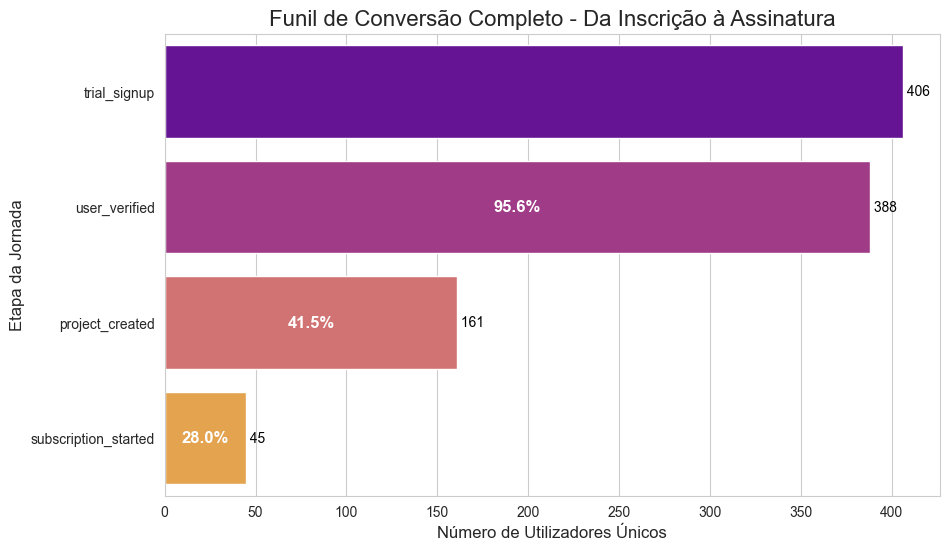

In [15]:
# --- CÉLULA 5: GRÁFICO 3 - FUNIL DE CONVERSÃO COMPLETO ---

# A nossa análise preditiva está quase completa. Já entendi COMO o modelo se
# comporta (distribuição) e ONDE ele encontra valor (campanhas). A peça final
# do quebra-cabeças é entender o PORQUÊ: qual é a jornada do utilizador que
# leva à conversão? Um funil é a ferramenta visual perfeita para mapear
# esta jornada e identificar os pontos de maior atrito.
# O meu objetivo é criar uma visualização clara que a equipa de produto da
# InsightOS possa usar para tomar decisões sobre onde focar os seus esforços
# de melhoria.
# ---

print("\nGerando Gráfico 3: Funil de Conversão...")

# --- 1. Definição da Jornada do Utilizador ---
# A primeira e mais importante parte da criação de um funil é definir a
# sequência lógica dos passos que um utilizador deve seguir.

print("   Passo 1/3: A definir as etapas do funil...")
funnel_order = ['trial_signup', 'user_verified', 'project_created', 'subscription_started']

# --- 2. Cálculo dos Utilizadores em Cada Etapa ---
# Para um funil preciso, eu não conto o número de eventos, mas sim o número
# de UTILIZADORES ÚNICOS (`nunique('visitor_id')`) que completaram cada etapa.
# Isto evita que um utilizador que criou dois projetos seja contado duas vezes.

print("   Passo 2/3: A calcular o número de utilizadores únicos por etapa...")
funnel_data = events_df.groupby('event_type')['visitor_id'].nunique().reindex(funnel_order).reset_index()
funnel_data.columns = ['Etapa', 'Número de Utilizadores']

# --- 3. Construção da Visualização do Funil ---
# Eu uso um gráfico de barras horizontais para simular a aparência de um funil.
# A parte mais valiosa aqui é a adição de anotações: o número absoluto de
# utilizadores e, crucialmente, a taxa de conversão entre cada etapa.

print("   Passo 3/3: A gerar a visualização do gráfico...")
plt.figure(figsize=(10, 6))

funnel_plot = sns.barplot(
    x='Número de Utilizadores',
    y='Etapa',
    data=funnel_data,
    palette='plasma',
    order=funnel_order,
    hue='Etapa',
    legend=False
)

plt.title('Funil de Conversão Completo - Da Inscrição à Assinatura', fontsize=16)
plt.xlabel('Número de Utilizadores Únicos', fontsize=12)
plt.ylabel('Etapa da Jornada', fontsize=12)

# Este loop complexo é o que torna o gráfico acionável. Ele percorre cada
# etapa e adiciona os rótulos de dados.

for i, etapa in enumerate(funnel_order):
    # Encontra o dado correspondente à etapa
    if etapa in funnel_data['Etapa'].values:
        count = funnel_data.loc[funnel_data['Etapa'] == etapa, 'Número de Utilizadores'].iloc[0]
        
        # Adiciona o número total de utilizadores
        funnel_plot.text(count, i, f' {count}', color='black', ha="left", va='center')
        
        # Calcula e adiciona a taxa de conversão a partir da etapa anterior
        if i > 0:
            prev_etapa = funnel_order[i-1]
            if prev_etapa in funnel_data['Etapa'].values:
                prev_count = funnel_data.loc[funnel_data['Etapa'] == prev_etapa, 'Número de Utilizadores'].iloc[0]
                if prev_count > 0: # Evita divisão por zero
                    conversion_rate = (count / prev_count) * 100
                    funnel_plot.text(count / 2, i, f'{conversion_rate:.1f}%', color='white', ha="center", va='center', fontsize=12, weight='bold')

plt.show()


O funil visualiza claramente a "saúde" do nosso produto e a jornada do utilizador. Cada barra representa uma etapa chave, e o seu tamanho indica o número de utilizadores únicos que a completaram, enquanto as percentagens mostram a taxa de conversão entre as etapas.

Principais Insights Obtidos:

Entrada do Funil Saudável (95.6%): A transição de trial_signup para user_verified é extremamente eficiente. Quase todos os utilizadores que se inscrevem conseguem verificar o seu e-mail, indicando que não há obstáculos técnicos nesta fase.

Ponto de Atrito Crítico (41.5%): A maior quebra em todo o funil ocorre entre a verificação do e-mail e a criação do primeiro projeto. Perdemos mais de metade dos nossos utilizadores engajados neste ponto. Este é o "buraco" no nosso balde.

Conversão Final (28.0%): A taxa de conversão de utilizadores que criaram um projeto para assinantes pagantes é de 28.0%. Embora seja uma quebra, é um número mais esperado para a transição de um serviço gratuito para um pago.

Implicações para a InsightOS: O insight mais acionável é o ponto de atrito na etapa de project_created. A recomendação estratégica para a equipa de produto é investigar e otimizar esta fase da experiência do utilizador. Simplificar a criação do primeiro projeto ou oferecer um onboarding mais guiado poderia ter um impacto significativo na taxa de conversão geral e, consequentemente, na receita.